<a href="https://colab.research.google.com/github/yinghong7/PySP/blob/master/Vibration_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

Mounted at /content/drive


In [ ]:
df_source = pd.read_csv ('/content/drive/MyDrive/EPD DATA/source_vibration_parsed.csv')
df_receiver = pd.read_csv ('/content/drive/MyDrive/EPD DATA/receiver_vibration_parsed.csv')
df_background = pd.read_csv ('/content/drive/MyDrive/EPD DATA/background_vibration_parsed.csv')
aco_source = pd.read_csv ('/content/drive/MyDrive/EPD DATA/source_vibration_acoustic.csv')
aco_receiver = pd.read_csv ('/content/drive/MyDrive/EPD DATA/receiver_vibration_acoustic.csv')
aco_background = pd.read_csv ('/content/drive/MyDrive/EPD DATA/background_vibration_acoustic.csv')

source = pd.read_csv ('/content/drive/MyDrive/EPD DATA/source_vibration_parsed.csv')
receiver = pd.read_csv ('/content/drive/MyDrive/EPD DATA/receiver_vibration_parsed.csv')


In [ ]:
for i in list(dict.fromkeys(df_source['Equipment'])):
  sub_a = df_source.loc[df_source['Equipment']== i]
  print ('Source: ', 'Equipment - ', i, 'Sample No - ', np.round(len(sub_a)/1000))
for i in list(dict.fromkeys(df_receiver['Equipment'])):
  sub_a = df_receiver.loc[df_receiver['Equipment']== i]
  print ('Receiver: ', 'Equipment - ', i, 'Sample No - ', np.round(len(sub_a)/1000))

Source:  Equipment -  Fastening machine Sample No -  23.0
Source:  Equipment -  Electrical drill Sample No -  63.0
Source:  Equipment -  Handheld less 10 Sample No -  54.0
Source:  Equipment -  Handheld over 10 Sample No -  45.0
Source:  Equipment -  Pneumatic driver Sample No -  34.0
Receiver:  Equipment -  Electrical drill Sample No -  102.0
Receiver:  Equipment -  Handheld less 10 Sample No -  72.0
Receiver:  Equipment -  Handheld over 10 Sample No -  89.0
Receiver:  Equipment -  Pneumatic driver Sample No -  22.0
Receiver:  Equipment -  Fastening machine Sample No -  38.0


In [ ]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_filter(df, lowcut, highcut):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 500.0
    lowcut = lowcut
    highcut = highcut
    sig = scipy.fft.fft (df['acc'].to_numpy()).real
    df ['Filtered_butter'] = butter_bandpass_filter(sig, lowcut, highcut, fs, order=3)

    return df

In [ ]:
import scipy
df_source_ = butter_filter (df_source, 0.01, 10)
df_receiver_ = butter_filter (df_receiver, 0.01, 10)
source_ = butter_filter (source, 0.01, 10)
receiver_ = butter_filter (receiver, 0.01, 10)
total = pd.concat ([df_source_, source_, df_receiver_, receiver_])
#aco_source_ = butter_filter (aco_source, 26, 60)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

def precision_recall_f1 (y_true, y_pred, dataset):
  print (dataset, 'Precision', sklearn.metrics.precision_score (y_true, y_pred))
  print (dataset, 'Recall', sklearn.metrics.recall_score (y_true, y_pred))
  print (dataset, 'F1', sklearn.metrics.f1_score (y_true, y_pred))

def svr_ (x, y):
  svr = SVR()
  parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':('scale', 'auto'), 'C': [1,10]}
  clf = GridSearchCV (svr, parameters)
  clf.fit (x, y)
  print ('Best parameters:',clf.best_params_, 'Score:',clf.score (x, y), 'Best estimator:', clf.best_estimator_)
  return clf.best_estimator_

In [ ]:
svr_ (df_source.iloc [:8235,7].to_numpy().reshape(8235,1), aco_source['Filtered_butter'].to_numpy().reshape(8235,1).ravel())

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} Score: -3.057152989516254e-05 Best estimator: SVR(C=10, kernel='linear')


SVR(C=10, kernel='linear')

**AI prediction**

In [ ]:
from itertools import chain
def get_cwt_feature (data, width):
  cwt_ = np.empty(shape = [0, 33])
  label = []
  for i in list(dict.fromkeys(total['Equipment'])):
    cwtmatr = scipy.signal.cwt(total['acc'].to_numpy(), scipy.signal.ricker, np.arange (3, 36))
    cwt_ = np.append (cwt_, np.transpose(cwtmatr), axis = 0)
    if i in ('Handheld over 10', 'Handheld less 10', 'Electrical drill'):
      label.append ([i]*cwtmatr.shape[1])
    else: label.append (['Others'] * cwtmatr.shape[1])
  label = list(chain.from_iterable(label))
  return cwt_, label


def get_log_feature (data, sample_rate, nperseg):
  label = []
  log_ = np.empty(shape = [257, 0])
  for i in list(dict.fromkeys(data['Equipment'])):
    sub = total.loc[(data['Equipment'] == i)]
    f_, t_, Zxx = scipy.signal.stft(sub['acc'].to_numpy(), sample_rate, nperseg = nperseg)
    log_spectrogram = librosa.amplitude_to_db(np.abs(Zxx))
    if i in ('Handheld over 10', 'Handheld less 10', 'Electrical drill'):
      label.append ([i]*log_spectrogram.shape[1])
    else: label.append (['Others'] * log_spectrogram.shape[1])
    log_ = np.append (log_, log_spectrogram, axis = 1)
  label = list(chain.from_iterable(label))
  return np.transpose (log_), label

In [ ]:
import librosa
cwt_, label_cwt = get_cwt_feature (total, np.arange (3,36))
log_, label_log = get_log_feature (total, 100, 512)
print(cwt_.shape, len(label_cwt), log_.shape, len (label_log))

(5421120, 33) 5421120 (4242, 257) 4242


In [ ]:
# Not filetered log_spectrogram and cwt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

log_train, log_test, log_y_train, log_y_test = train_test_split(log_, label_log, test_size=0.33, random_state=42)
cwt_train, cwt_test, cwt_y_train, cwt_y_test = train_test_split(cwt_, label_cwt, test_size=0.33, random_state=42)

In [ ]:
#filtered fft as the feature
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV

def decision_tree (x, y):
  from sklearn import tree
  from sklearn.model_selection import GridSearchCV
  tree_ = tree.DecisionTreeClassifier()
  parameters = {'criterion': ('gini', 'entropy', 'log_loss'), 'max_depth': [2,8]}
  clf = GridSearchCV (tree_, parameters)
  clf.fit (x,y)
  print ('Best parameters:',clf.best_params_, 'Score:',clf.score (x,y), 'Best estimator:',clf.best_estimator_)
  return clf.best_estimator_

def precision_recall_f1 (y_true, y_pred, dataset):
  import sklearn
  print (dataset, 'Precision', sklearn.metrics.precision_score (y_true, y_pred, average = 'weighted'))
  print (dataset, 'Recall', sklearn.metrics.recall_score (y_true, y_pred, average = 'weighted'))
  print (dataset, 'F1', sklearn.metrics.f1_score (y_true, y_pred, average = 'weighted'))

def svc_ (x, y):
  from sklearn.svm import SVC
  from sklearn.model_selection import GridSearchCV
  svc = SVC()
  parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':('scale', 'auto'), 'C': [1,10]}
  clf = GridSearchCV (svc, parameters)
  clf.fit (x, y)
  print ('Best parameters:',clf.best_params_, 'Score:',clf.score (x, y), 'Best estimator:', clf.best_estimator_)
  return clf.best_estimator_

**Log spectrogram and CWT**

In [ ]:
log_tree = decision_tree (log_train, log_y_train)
precision_recall_f1 (log_y_test, log_tree.predict (log_test), 'Test')
precision_recall_f1 (log_y_train, log_tree.predict (log_train), 'Train')

Best parameters: {'criterion': 'entropy', 'max_depth': 8} Score: 0.8353272343420126 Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=8)
Test Precision 0.7305765230819223
Test Recall 0.7328571428571429
Test F1 0.7300498400248863
Train Precision 0.8426050291284302
Train Recall 0.8353272343420126
Train F1 0.8351206884436078


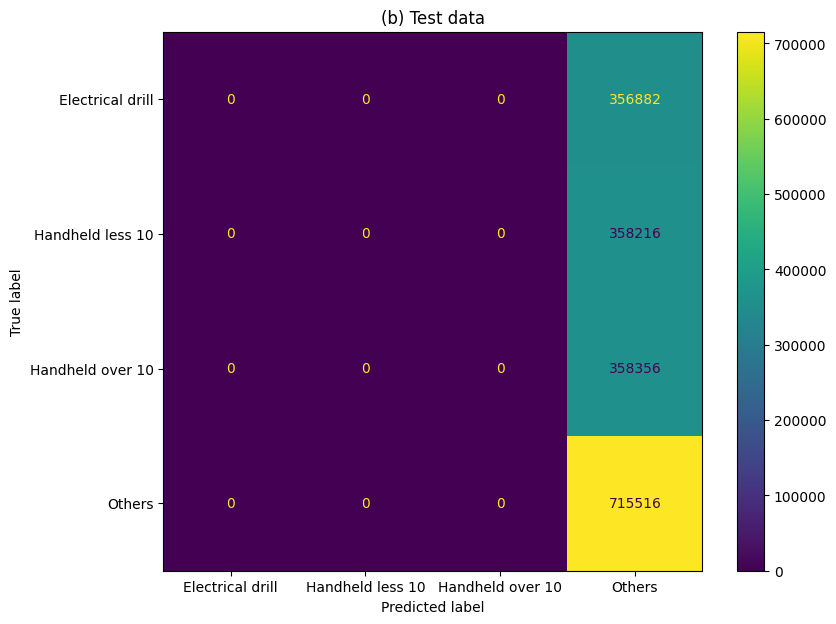

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(cwt_y_test, cwt_tree.predict (cwt_test), labels=cwt_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cwt_tree.classes_)
fig, ax = plt.subplots(figsize=(9,7))
disp.plot(ax = ax)
plt.title ('(b) Test data')
plt.show()

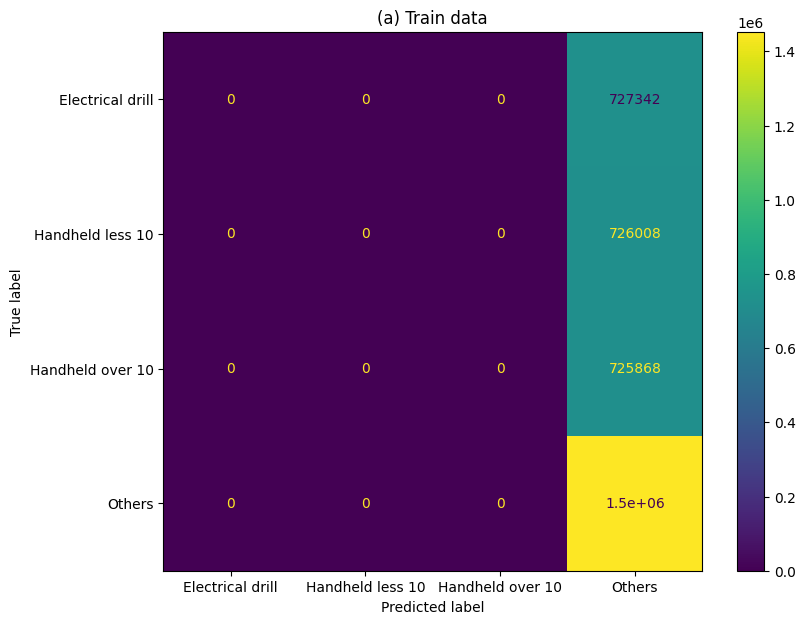

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(cwt_y_train, cwt_tree.predict (cwt_train), labels=cwt_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cwt_tree.classes_)
fig, ax = plt.subplots(figsize=(9,7))
disp.plot(ax = ax)
plt.title ('(a) Train data')
plt.show()

In [ ]:
cwt_tree = decision_tree (cwt_train, cwt_y_train)
precision_recall_f1 (cwt_y_test, cwt_tree.predict (cwt_test), 'Test')
precision_recall_f1 (cwt_y_train, cwt_tree.predict (cwt_train), 'Train')

Best parameters: {'criterion': 'gini', 'max_depth': 2} Score: 0.4000198229698663 Best estimator: DecisionTreeClassifier(max_depth=2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision 0.1599678043219041
Test Recall 0.3999597533776419
Test F1 0.2285320044893497


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Precision 0.1600158587688432
Train Recall 0.4000198229698663
Train F1 0.2285908472772922


In [ ]:
log_svc = svc_ (log_train, log_y_train)
precision_recall_f1 (log_y_test, log_svc.predict (log_test), 'Test')
precision_recall_f1 (log_y_train, log_svc.predict (log_train), 'Train')

**LSTM-RNN**

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, Softmax
from keras.models import Model
from keras import regularizers
import keras
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

def reshape (train, test, y_train, y_test):
  scaler = MinMaxScaler()
  train = scaler.fit_transform(train)
  test = scaler.transform (test)
  x_train = train.reshape(train.shape[0], 1, train.shape[1])
  x_test = test.reshape(test.shape[0], 1, test.shape[1])
  enc = OneHotEncoder ()
  y_train = enc.fit_transform (np.array(y_train).reshape (len(y_train), 1)).toarray()
  y_test = enc.fit_transform (np.array(y_test).reshape (len(y_test), 1)).toarray()
  return x_train, x_test, y_train, y_test


def oned_model (X):
    model = keras.Sequential ()
    model.add (keras.Input (shape = (X.shape[1], X.shape[2])))
    model.add (Dense(10))
    model.add (LSTM (10))
    model.add(Dense(4, activation='softmax'))
    return model

In [ ]:
log_train_, log_test_, log_y_train_, log_y_test_ = reshape (log_train, log_test, log_y_train, log_y_test)
model2 = oned_model (log_train_)
model2.summary ()
model2.compile (optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
hisory = model2.fit (log_train_, log_y_train_, epochs=100, verbose = 1, validation_split= 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 10)             2580      
                                                                 
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 3464 (13.53 KB)
Trainable params: 3464 (13.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 5s 14ms/step - loss: 1.3349 - accuracy: 0.2934 - mse: 0.1798 - val_loss: 1.2878 - val_accuracy: 0.3199 - val_mse: 0.1731
Epoch 2/100
72/72 [==============================] - 0s 4ms/step - loss: 1.2831 - accuracy: 0.3247 - mse: 0.1721

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


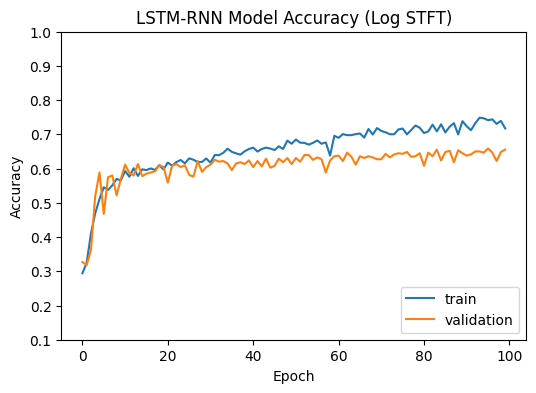

In [ ]:
print(hisory.history.keys())
plt.figure (figsize = (6,4))
plt.plot(hisory.history['accuracy'])
plt.plot(hisory.history['val_accuracy'])
plt.title('LSTM-RNN Model Accuracy (CWT)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim (0.1, 1.0)
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

89/89 [==============================] - 0s 4ms/step


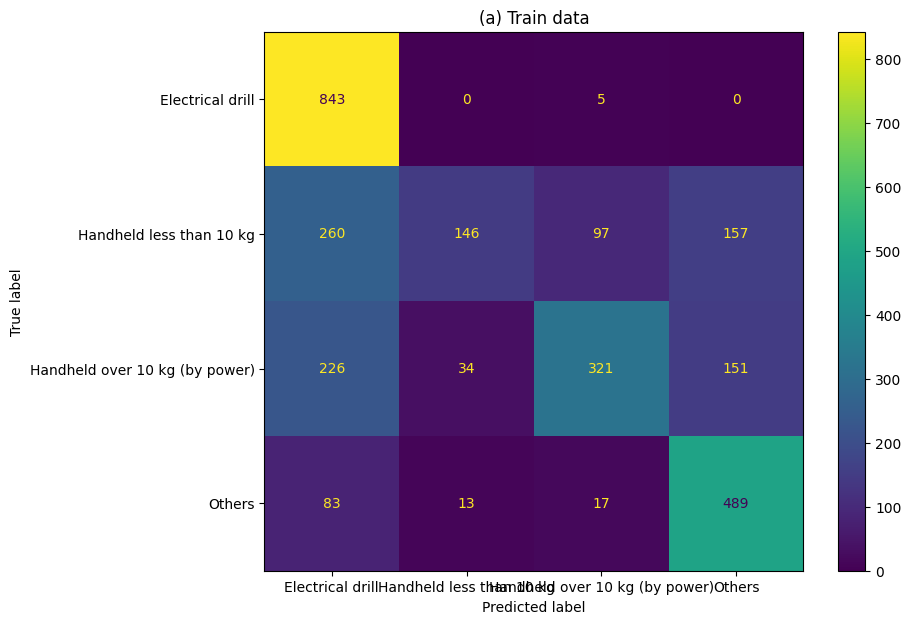

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
l = ['Electrical drill', 'Handheld less than 10 kg', 'Handheld over 10 kg (by power)', 'Others']
#y_true = log_y_test_.argmax(axis=1)
#y_pred = np.round(model2.predict (log_test_)).argmax(axis=1)
cm = confusion_matrix(log_y_train_.argmax(axis=1), np.round(model2.predict (log_train_)).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)
fig, ax = plt.subplots(figsize=(9,7))
disp.plot(ax = ax)
plt.title ('(a) Train data')
plt.show()

In [ ]:
import sklearn
y_pred_1 = model2.predict (cwt_test_)
y_pred_2 = model2.predict (cwt_train_)

print ("Train precision", sklearn.metrics.precision_score(cwt_y_train_, np.round(y_pred_2), average = 'weighted'))
print ("Train recall", sklearn.metrics.recall_score(cwt_y_train_, np.round(y_pred_2), average = 'weighted'))
print ("Train F1", sklearn.metrics.f1_score(cwt_y_train_, np.round(y_pred_2), average = 'weighted'))

print ("Test precision", sklearn.metrics.precision_score(cwt_y_test_, np.round(y_pred_1), average = 'weighted'))
print ("Test recall", sklearn.metrics.recall_score(cwt_y_test_, np.round(y_pred_1), average = 'weighted'))
print ("Test F1", sklearn.metrics.f1_score(cwt_y_test_, np.round(y_pred_1), average = 'weighted'))

89/89 [==============================] - 0s 4ms/step
Train precision 0.777686900845642
Train recall 0.633356790992259
Train F1 0.679524586579994
Test precision 0.6750752786040146
Test recall 0.5642857142857143
Test F1 0.5991216720094327


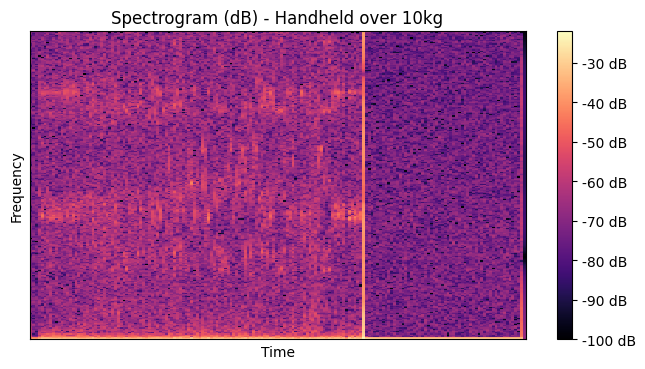

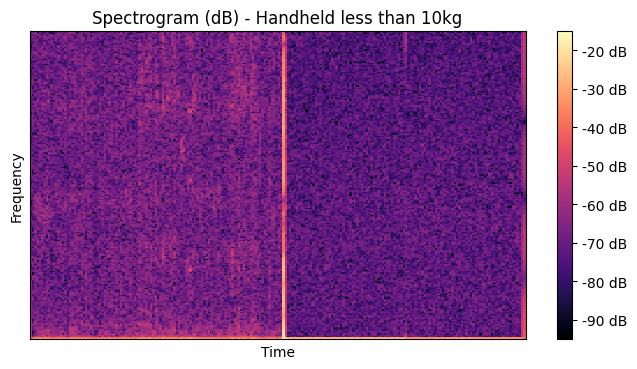

In [ ]:
def log_stft_plot (log_spectrogram, sample_rate, FIG_SIZE, nperseg, title):
  plt.figure (figsize = FIG_SIZE)
  librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length = nperseg - nperseg//2)
  plt.xlabel("Time")
  plt.ylabel ('Frequency')
  plt.colorbar(format="%+2.0f dB")
  plt.title (title)
  plt.show ()
log_stft_plot (log_over10, 100, (8,4), 512, "Spectrogram (dB) - Handheld over 10kg")
log_stft_plot (log_less10, 100, (8,4), 512, "Spectrogram (dB) - Handheld less than 10kg")